<a href="https://colab.research.google.com/github/Gagandheep/AutoEncoder/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from IPython.display import display, Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from tqdm import tqdm_notebook as tqdm
from shutil import copyfile
tqdm().pandas()
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [6]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-90885fa3-257c-8dc0-844c-d920775417fd)


In [ ]:
!wget -O data.zip http://images.cocodataset.org/zips/test2017.zip

--2021-03-05 11:45:54--  http://images.cocodataset.org/zips/test2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.43.68
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.43.68|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6646970404 (6.2G) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   6.19G  16.5MB/s    in 6m 28s  

2021-03-05 11:52:22 (16.4 MB/s) - ‘data.zip’ saved [6646970404/6646970404]



In [ ]:
!rm -rf sample_data/
!unzip -q data.zip -d data/

In [8]:
data_dir = 'data/test2017/'
train_dir = 'train/'
test_dir = 'test/'
val_dir = 'val/'

In [ ]:
!rm -rf train test val
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')
os.mkdir('train/data')
os.mkdir('test/data')
os.mkdir('val/data')

In [ ]:
i = 0

for img in tqdm(os.listdir(data_dir)):
    if i < 2000:
        curr_dir = val_dir
    elif i < 4000:
        curr_dir = test_dir
    else:
        curr_dir = train_dir
    
    i += 1

    copyfile(data_dir + img, curr_dir + 'data/' + img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
datagen = ImageDataGenerator(rescale = 1.0/255.)

batch_size = 64

train_generator = datagen.flow_from_directory(train_dir,
                                              class_mode='input',
                                              batch_size=batch_size)     

validation_generator = datagen.flow_from_directory(val_dir,
                                                   class_mode='input',
                                                   batch_size=batch_size)

test_generator = datagen.flow_from_directory(test_dir,
                                             class_mode='input',
                                             batch_size=batch_size)

Found 36670 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.


In [10]:
# Define model
img_in = tf.keras.Input((256, 256, 3))

c1 = Conv2D(16, (3, 3), padding='same')(img_in)
m1 = MaxPooling2D()(c1)

c2 = Conv2D(32, (3, 3), padding='same')(m1)
m2 = MaxPooling2D()(c2)

c3 = Conv2D(64, (3, 3), padding='same')(m2)
m3 = MaxPooling2D()(c3)

c4 = Conv2D(128, (3, 3), padding='same')(m3)
m4 = MaxPooling2D()(c4)

out = Flatten()(m4)

vec_in = tf.reshape(out, [-1, 16, 16, 128])

c5 = Conv2D(16, (3, 3), padding='same')(vec_in)
u1 = UpSampling2D()(c5)

c6 = Conv2D(32, (3, 3), padding='same')(u1)
u2 = UpSampling2D()(c6)

c7 = Conv2D(64, (3, 3), padding='same')(u2)
u3 = UpSampling2D()(c7)

c8 = Conv2D(128, (3, 3), padding='same')(u3)
u4 = UpSampling2D()(c8)

c9 = Conv2D(3, (3, 3), padding='same')(u4)


In [11]:
model = tf.keras.Model(inputs=img_in, outputs=c9)
model.compile('adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0     

In [14]:
model.fit(train_generator, validation_data=validation_generator, epochs=3, shuffle=True)

Epoch 1/3
573/573 [==============================] - 619s 1s/step - loss: 0.0282 - accuracy: 0.6812 - val_loss: 0.0157 - val_accuracy: 0.7232
Epoch 2/3
573/573 [==============================] - 611s 1s/step - loss: 0.0150 - accuracy: 0.7381 - val_loss: 0.0143 - val_accuracy: 0.7472
Epoch 3/3
573/573 [==============================] - 613s 1s/step - loss: 0.0141 - accuracy: 0.7508 - val_loss: 0.0136 - val_accuracy: 0.7526


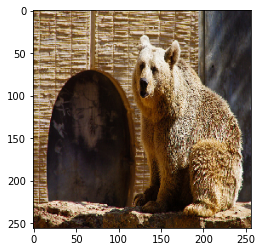

In [24]:
x, _ = test_generator.next()
image = x[0]
plt.imshow(image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


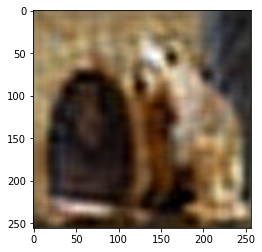

In [25]:
ret = model(image.reshape((-1, 256, 256, 3)))
plt.imshow(ret[0])
plt.show()